In [352]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

from copy import deepcopy

SEED_COLNAME = "ModelSeed"
LR_COLNAME = 'LearningRate'

YMIN = -0.01
YMAX = 0.72

YMAX_ext = 0.8

sns.set_theme(font_scale=1.3)


In [353]:
# for argument parsing
def parse_string_arg(string_arg):
    return string_arg.split(',')


def list_to_string(_list):
    output = ""
    for thing in _list:
        output += str(thing) + '_'
    output = output[:-1]
    return output

def insert_seeds_into_dict(_dict, seeds=[10, 11, 12, 13, 14]):
    dict_with_seeds = {}
    for key, value in _dict.items():
        for seed in seeds:
            seeded_key = key+'_'+str(seed)
            dict_with_seeds[seeded_key] = deepcopy(value)
            dict_with_seeds[seeded_key][SEED_COLNAME] = seed
    return dict_with_seeds


def insert_lrs_into_dict(_dict, lrs=[0.0001, 0.0002, 0.0003, 0.0004, 0.0005]):
    dict_with_lrs = {}
    for key, value in _dict.items():
        for lr in lrs:
            key_with_lr = key+'_'+str(lr)
            dict_with_lrs[key_with_lr] = deepcopy(value)
            dict_with_lrs[key_with_lr][LR_COLNAME] = lr
    return dict_with_lrs
     

    """
    
    """

In [354]:
module_path = '/home/edwardsb/repositories/be-SATGOpenFL/openfl-tutorials/experimental/FL_With_Diffusion'

lr_strings = [ '0.11'] 

base_options = {'tuning':
                    {'held_classes': [],
                       'synth_classes': [], 
                       'hold_from_cols': [], 
                       'synth_to_cols': [], 
                       'num_cols': 5, 
                       SEED_COLNAME: 999},
                'baseline_centralized':
                      {'held_classes': [],
                       'synth_classes': [], 
                       'hold_from_cols': [], 
                       'synth_to_cols': [], 
                       'num_cols': 1, 
                       LR_COLNAME: 0.0003},
                'baseline_FL':
                      {'held_classes': [],
                       'synth_classes': [], 
                       'hold_from_cols': [], 
                       'synth_to_cols': [], 
                       'num_cols': 5, 
                       LR_COLNAME: 0.0003}, 
            'allmissing_two':
                      {'held_classes': [1,6],
                       'synth_classes': [], 
                       'hold_from_cols': [0, 1, 2, 3, 4], 
                       'synth_to_cols': [], 
                       'num_cols': 5, 
                       LR_COLNAME: 0.0003},
            'allmissing_two_allsupp_one':
                      {'held_classes': [1,6],
                       'synth_classes': [6], 
                       'hold_from_cols': [0, 1, 2, 3, 4], 
                       'synth_to_cols': [0, 1, 2, 3, 4], 
                       'num_cols': 5, 
                       LR_COLNAME: 0.0003}
            
           }

In [355]:


def get_results_path(held_classes, synth_classes, hold_from_cols, synth_to_cols, LearningRate, num_cols=None, ModelSeed=None):
    return os.path.join(module_path, 
                        'Results', 
                        f'v2fed_results_missing_{list_to_string(held_classes)}_holding_from_{list_to_string(hold_from_cols)}_supplementing_{list_to_string(synth_to_cols)}_with_synth_classes_{list_to_string(synth_classes)}_lr_{LearningRate}_num_cols_{num_cols}_model_seed_{ModelSeed}.csv')


def get_rpaths_keynamevalues(options_dict, keyname):
    rpaths_keynamevalues = {}
    for key in options_dict:
        rpaths_keynamevalues[key] = {'path': get_results_path(**(options_dict[key])), 'keyname_value': options_dict[key][keyname]}
    return rpaths_keynamevalues


def accumulate_dfs(rpaths_keynamevalues, keyname):
    """
    rpaths_keynamevalues (dict): option to inner_dict: inner_dict takes 'path' to results path and 'keyname_value' to the value in the options_dict associated to keyname. If results_path is None this indicates that there is 
                                 a third key, 'dataframe' whose value provides the dataframe rather than requiring a load from path.
    keyname (str): Key name from rpaths dict that needs to be included in dataframe. It may already be a column in the results dataframe, but if not needs to be inserted as new column (examples are 'OLDMODEL', 'SupplementSize')
                    An exception is thrown if keyname is a column in the results dataframe but does not hold exclusively the value provided in rpaths_keynames_values
    
    """
    results_df = None
    for key, inner_dict in rpaths_keynamevalues.items():
        path = inner_dict['path']
        keyname_value = inner_dict['keyname_value']
        if path is not None:
            df = pd.read_csv(path)
        elif 'dataframe' in inner_dict:
            df = inner_dict['dataframe']
        else:
            raise ValueError(f"A path of None was provided without utilizing the 'dataframe' key for the inner dict of rpaths_keynamevalues dictionary for that option.")
        # print(F"Columns of df read from: {path} are: {df.columns}")
        if keyname in df.columns:
            if not (df[keyname]==keyname_value).all():
                raise ValueError(f"Results dataframe for key:{key} was found to have unique values: {df[keyname].unique()} when the options dict said the value should be only: {keyname_value}.")
        else:
            df[keyname] = keyname_value
        # special exception for LR_COLNAME
        if keyname == LR_COLNAME:
            df[LR_COLNAME] = keyname_value
        if results_df is None:
            results_df = df
        else:
            results_df = pd.concat([results_df, df], axis=0)
    return results_df





In [356]:
# tuning_dict = {lr: results_paths[f"tuning_{lr}"]for lr in [0.0001, 0.0002, 0.0003, 0.0004, 0.0005]}
# baseline_dict = {seed: results_paths[f"baseline_{seed}"] for seed in [10, 11, 12, 13, 14]}

# tuning_options = insert_lrs_into_dict(_dict={'tuning': base_options['tuning']})
                                        
baseline_centralized_options = insert_seeds_into_dict(_dict={'baseline_centralized': base_options['baseline_centralized']})

baseline_FL_options = insert_seeds_into_dict(_dict={'baseline_FL': base_options['baseline_FL']})

allmissing_two_options = insert_seeds_into_dict(_dict={'allmissing_two': base_options['allmissing_two']})

allmissing_two_suppone_options = insert_seeds_into_dict(_dict={'allmissing_two_allsupp_one': base_options['allmissing_two_allsupp_one']})

                                        



In [357]:
# tuning_options

In [358]:
baseline_centralized_options

{'baseline_centralized_10': {'held_classes': [],
  'synth_classes': [],
  'hold_from_cols': [],
  'synth_to_cols': [],
  'num_cols': 1,
  'LearningRate': 0.0003,
  'ModelSeed': 10},
 'baseline_centralized_11': {'held_classes': [],
  'synth_classes': [],
  'hold_from_cols': [],
  'synth_to_cols': [],
  'num_cols': 1,
  'LearningRate': 0.0003,
  'ModelSeed': 11},
 'baseline_centralized_12': {'held_classes': [],
  'synth_classes': [],
  'hold_from_cols': [],
  'synth_to_cols': [],
  'num_cols': 1,
  'LearningRate': 0.0003,
  'ModelSeed': 12},
 'baseline_centralized_13': {'held_classes': [],
  'synth_classes': [],
  'hold_from_cols': [],
  'synth_to_cols': [],
  'num_cols': 1,
  'LearningRate': 0.0003,
  'ModelSeed': 13},
 'baseline_centralized_14': {'held_classes': [],
  'synth_classes': [],
  'hold_from_cols': [],
  'synth_to_cols': [],
  'num_cols': 1,
  'LearningRate': 0.0003,
  'ModelSeed': 14}}

In [359]:
def get_AllCols_aggmodel_acc(df):
    return df[(df['Location']=='All') & (df['Metric']=='Aggregated Model Accuracy')]

In [360]:
def augment_inner_dict(option, df, inner_dict):
    option_dict = {'path': None, 'keyname_value': option, 'dataframe': df}
    if not inner_dict:
        inner_dict = {option: option_dict}
    elif option in inner_dict:
        raise ValueError(f"Trying to add option:{option} to dict: {inner_dict} when it alread has that option as a key.")
    else:
        inner_dict[option] = option_dict
    return inner_dict   


def build_final_df(options, dfs):
    """
    using accumulate_dfs to build up final df to hold everything
    """
    optdict = None
    for option, df in zip(options, dfs):
        optdict = augment_inner_dict(option=option, df=df, inner_dict=optdict)

    return accumulate_dfs(rpaths_keynamevalues=optdict, keyname='Data Configuration')

In [361]:
# tuning_df = get_AllCols_aggmodel_acc(df=accumulate_dfs(rpaths_keynamevalues=get_rpaths_keynamevalues(options_dict=tuning_options, keyname=LR_COLNAME), keyname=LR_COLNAME))
baseline_centralized_df = get_AllCols_aggmodel_acc(df=accumulate_dfs(rpaths_keynamevalues=get_rpaths_keynamevalues(options_dict=baseline_centralized_options, keyname=SEED_COLNAME), keyname=SEED_COLNAME))
baseline_FL_df = get_AllCols_aggmodel_acc(df=accumulate_dfs(rpaths_keynamevalues=get_rpaths_keynamevalues(options_dict=baseline_FL_options, keyname=SEED_COLNAME), keyname=SEED_COLNAME))
allmissing_two_df = get_AllCols_aggmodel_acc(df=accumulate_dfs(rpaths_keynamevalues=get_rpaths_keynamevalues(options_dict=allmissing_two_options, keyname=SEED_COLNAME), keyname=SEED_COLNAME))
allmissing_two_suppone_df = get_AllCols_aggmodel_acc(df=accumulate_dfs(rpaths_keynamevalues=get_rpaths_keynamevalues(options_dict=allmissing_two_suppone_options, keyname=SEED_COLNAME), keyname=SEED_COLNAME))


options = ['Centralized', 'FL', 'FL without Autos & Frogs', 'FL without Autos, Synthetic Frogs']
dfs = [baseline_centralized_df, baseline_FL_df, allmissing_two_df, allmissing_two_suppone_df]

# And finally putting these all together 
final_df = build_final_df(options=options, dfs=dfs)




In [362]:
final_df.columns

Index(['Round', 'Location', 'Label', 'Metric', 'Metric Value', 'ModelSeed',
       'Data Configuration'],
      dtype='object')

In [363]:
def my_plot(df, hue=None, replace_metric_value_string=None, title=None, title_size=18, ymin=YMIN, ymax=YMAX, image_folder=image_folder, fname='DEFAULT_DELETE_ME.png'):
    if replace_metric_value_string:
        df.rename(columns={'Metric Value': replace_metric_value_string}, inplace=True)
    else:
        replace_metric_value_string = 'Metric Value'
    if not hue:
        ax = sns.lineplot(df , x='Round', y=replace_metric_value_string)
    else:
        ax = sns.lineplot(df, x='Round', y=replace_metric_value_string, hue=hue)
    ax.set_ylim(ymin, ymax)

    if title:
        ax.set_title( title , size = title_size )


def my_plot_over_labels(df, **kwargs):
    my_plot(df, hue='Label') 


def my_plot_ave_label(df, **kwargs):
     df = df[df['Label']=='AVE']
     my_plot(df, **kwargs)


def my_plot_one_label(df, label, **kwargs):
    df = df[df['Label']==label]
    my_plot(df, **kwargs)


In [364]:
baseline_centralized_df.columns #, tuning_dict.columns

Index(['Round', 'Location', 'Label', 'Metric', 'Metric Value', 'ModelSeed',
       'Data Configuration'],
      dtype='object')

In [365]:
baseline_centralized_df['Location'].unique(), baseline_centralized_df['Metric'].unique(), baseline_centralized_df['ModelSeed'].unique()

(array(['All'], dtype=object),
 array(['Aggregated Model Accuracy'], dtype=object),
 array([10, 11, 12, 13, 14]))

In [366]:
"""
Ok, how do each class do in the baseline scenario?

"""

'\nOk, how do each class do in the baseline scenario?\n\n'

In [367]:

"""

def get_target_acc_for_aggmodel(df, label):
    return df[(df['Location']=='All') & (df['Metric']=='Aggregated Model Accuracy') & (df['Label'] == label)]


def get_target_acc_for_aggmodel_AVE(df):
    return df[(df['Location']=='All') & (df['Metric']=='Aggregated Model Accuracy') & (df['Label'] == 'AVE')]

"""

"\n\ndef get_target_acc_for_aggmodel(df, label):\n    return df[(df['Location']=='All') & (df['Metric']=='Aggregated Model Accuracy') & (df['Label'] == label)]\n\n\ndef get_target_acc_for_aggmodel_AVE(df):\n    return df[(df['Location']=='All') & (df['Metric']=='Aggregated Model Accuracy') & (df['Label'] == 'AVE')]\n\n"

In [368]:
"""
missing_1_dfs = {}
for label in ['1', '2', '3', '4', '5', '6', '7', '8', '9']:
    missing_1_dfs[label] = get_target_acc_for_aggmodel(df=accumulate_dfs({f'tar{target}_all_missing': results_paths[f'tar{target}_all_missing']}, cross_rpath_feature_name="option"), label=label)
"""

'\nmissing_1_dfs = {}\nfor label in [\'1\', \'2\', \'3\', \'4\', \'5\', \'6\', \'7\', \'8\', \'9\']:\n    missing_1_dfs[label] = get_target_acc_for_aggmodel(df=accumulate_dfs({f\'tar{target}_all_missing\': results_paths[f\'tar{target}_all_missing\']}, cross_rpath_feature_name="option"), label=label)\n'

In [369]:
# all_synth_frogs_df = get_target_acc_for_aggmodel(df=accumulate_dfs({'all_synth': results_paths['all_synth']}, cross_rpath_feature_name="option"), label='6')

In [370]:
# tuning_AllCols_aggmodel_acc= get_AllCols_aggmodel_acc(df=tuning_df)

In [371]:
# tuning_AllCols_aggmodel_acc_AVE= get_target_acc_for_aggmodel_AVE(df=tuning_df)

In [372]:
# tuning_AllCols_aggmodel_acc.columns

In [373]:
# df = tuning_AllCols_aggmodel_acc_AVE
# df[(df['Round']==0)]

In [374]:
# sns.lineplot(tuning_AllCols_aggmodel_acc , x='Round', y='Metric Value', hue='Label')

In [375]:

# sns.lineplot(tuning_AllCols_aggmodel_acc_AVE , x='Round', y='Metric Value', hue=LR_COLNAME)

In [376]:
final_df.columns

Index(['Round', 'Location', 'Label', 'Metric', 'Metric Value', 'ModelSeed',
       'Data Configuration'],
      dtype='object')

In [377]:
final_df['Location'].unique(), final_df['Metric'].unique(), final_df['Data Configuration'].unique(), final_df['Label'].unique()

(array(['All'], dtype=object),
 array(['Aggregated Model Accuracy'], dtype=object),
 array(['Centralized', 'FL', 'FL without Autos & Frogs',
        'FL without Autos, Synthetic Frogs'], dtype=object),
 array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'AVE'],
       dtype=object))

/tmp/ipykernel_1886748/1546615458.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'Metric Value': replace_metric_value_string}, inplace=True)


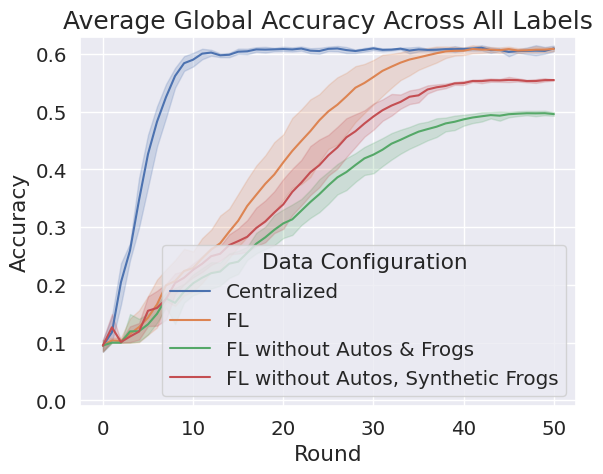

In [378]:
my_plot_ave_label(df=final_df, hue='Data Configuration', replace_metric_value_string='Accuracy', title='Average Global Accuracy Across All Labels', ymax=0.63)

In [379]:
# What if we evaluate how well we do if we ignore automobile classs scores (will need to manually average after removing automobile class results)
without_autos_df = final_df[(~final_df.Label.isin(['AVE', '1']))]
print(f"Unique labels once autos and ave removed are: {without_autos_df['Label'].unique()}") 


Unique labels once limited are: ['0' '2' '3' '4' '5' '6' '7' '8' '9']


In [380]:
test_df = without_autos_df.groupby(['Data Configuration', 'Label', 'Round'])[['Metric Value']].mean()
test_df

Metric Value
Data Configuration                Label Round              
Centralized                       0     0            0.0624
                                        1            0.2332
                                        2            0.0688
                                        3            0.2646
                                        4            0.3456
...                                                     ...
FL without Autos, Synthetic Frogs 9     46           0.7710
                                        47           0.7664
                                        48           0.7626
                                        49           0.7584
                                        50           0.7626

[1836 rows x 1 columns]

In [381]:
# but let's take the mean over seeds and labels
ave_without_autos_df = without_autos_df.groupby(['Data Configuration', 'Round'])[['Metric Value']].mean()
ave_without_autos_df

Metric Value
Data Configuration                Round              
Centralized                       0          0.102133
                                  1          0.098311
                                  2          0.213000
                                  3          0.255756
                                  4          0.340711
...                                               ...
FL without Autos, Synthetic Frogs 46         0.616400
                                  47         0.614578
                                  48         0.614644
                                  49         0.616378
                                  50         0.616556

[204 rows x 1 columns]

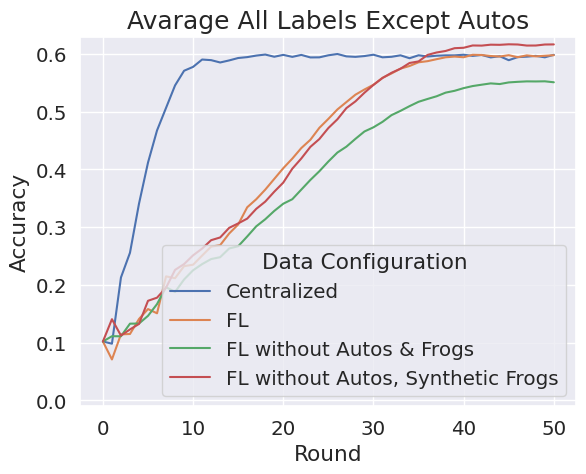

In [452]:
my_plot(df=ave_without_autos_df, replace_metric_value_string='Accuracy', hue='Data Configuration', title='Avarage All Labels Except Autos', ymax=0.63)

In [441]:
# Now remove Trucks to show that the increase above was only due to that class getting better in the absense of cars
without_autosNtrucks_df = final_df[(~final_df.Label.isin(['AVE', '1', '9']))]
print(f"Unique labels once autos, trucks and ave removed are: {without_autosNtrucks_df['Label'].unique()}") 

Unique labels once autos, trucks and ave removed are: ['0' '2' '3' '4' '5' '6' '7' '8']


In [442]:
# but let's take the mean over seeds and labels
ave_without_autosNtrucks_df = without_autosNtrucks_df.groupby(['Data Configuration', 'Round'])[['Metric Value']].mean()
ave_without_autosNtrucks_df

Metric Value
Data Configuration                Round              
Centralized                       0          0.100325
                                  1          0.110150
                                  2          0.219050
                                  3          0.246200
                                  4          0.330950
...                                               ...
FL without Autos, Synthetic Frogs 46         0.597075
                                  47         0.595600
                                  48         0.596150
                                  49         0.598625
                                  50         0.598300

[204 rows x 1 columns]

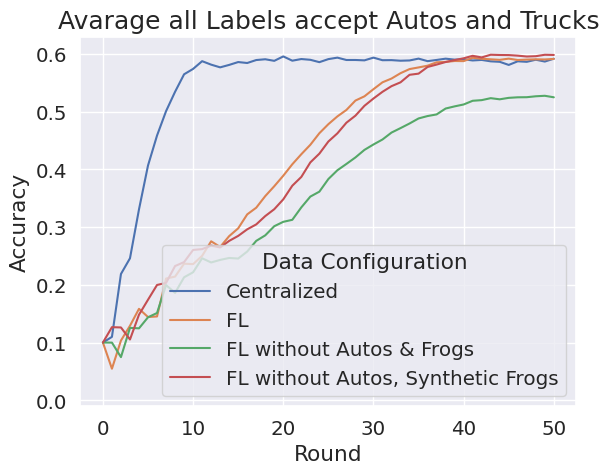

In [451]:
my_plot(df=ave_without_autosNtrucks_df, replace_metric_value_string='Accuracy', hue='Data Configuration', title='Avarage all Labels accept Autos and Trucks', ymax=0.63)

In [ ]:
"""
Below is what was used to discover the trucks issue

"""

In [384]:
 # On what classes are we beating performance from the regular setting?

/tmp/ipykernel_1886748/1546615458.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'Metric Value': replace_metric_value_string}, inplace=True)


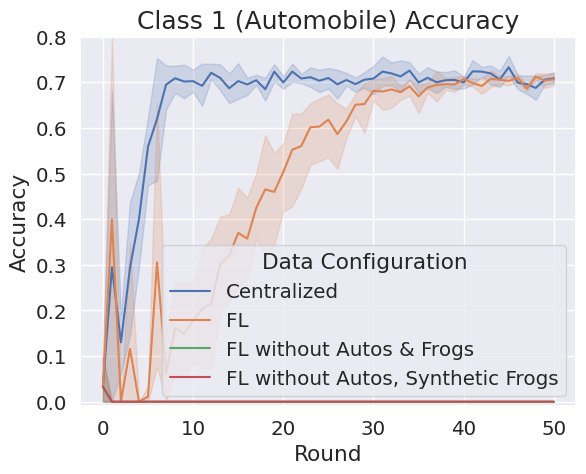

In [453]:
my_plot_one_label(df=final_df, label='1', hue='Data Configuration', replace_metric_value_string='Accuracy', title='Class 1 (Automobile) Accuracy', ymax=YMAX_ext)

/tmp/ipykernel_1886748/1546615458.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'Metric Value': replace_metric_value_string}, inplace=True)


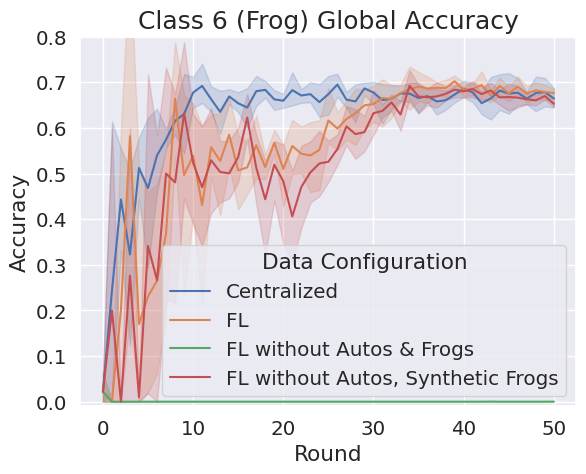

In [386]:
my_plot_one_label(df=final_df, label='6', hue='Data Configuration', replace_metric_value_string='Accuracy', title='Class 6 (Frog) Global Accuracy', ymax=YMAX_ext)

/tmp/ipykernel_1886748/1546615458.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'Metric Value': replace_metric_value_string}, inplace=True)


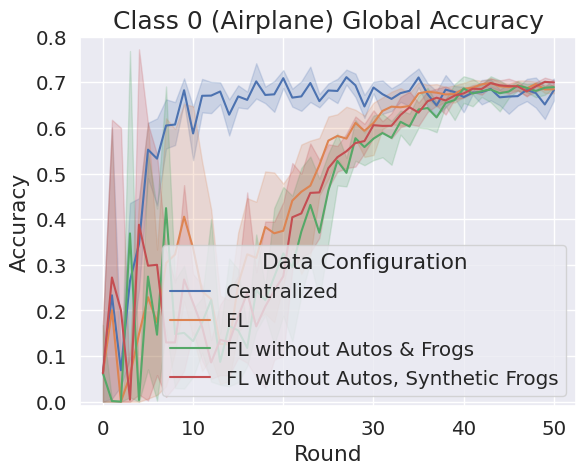

In [387]:
my_plot_one_label(df=final_df, label='0', hue='Data Configuration', replace_metric_value_string='Accuracy', title='Class 0 (Airplane) Global Accuracy', ymax=YMAX_ext)

/tmp/ipykernel_1886748/1546615458.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'Metric Value': replace_metric_value_string}, inplace=True)


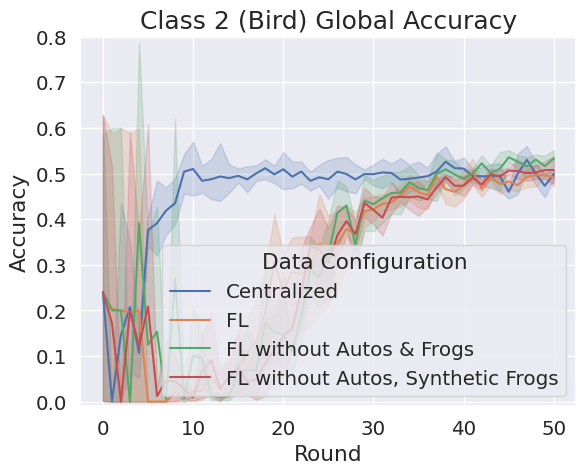

In [388]:
my_plot_one_label(df=final_df, label='2', hue='Data Configuration', replace_metric_value_string='Accuracy', title='Class 2 (Bird) Global Accuracy', ymax=YMAX_ext)

/tmp/ipykernel_1886748/1546615458.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'Metric Value': replace_metric_value_string}, inplace=True)


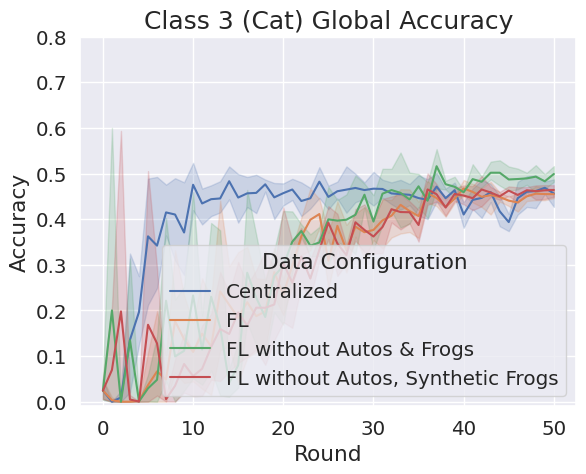

In [389]:
my_plot_one_label(df=final_df, label='3', hue='Data Configuration', replace_metric_value_string='Accuracy', title='Class 3 (Cat) Global Accuracy', ymax=YMAX_ext)

/tmp/ipykernel_1886748/1546615458.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'Metric Value': replace_metric_value_string}, inplace=True)


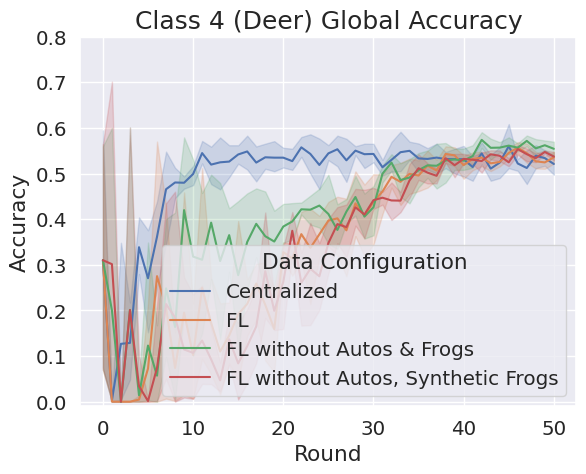

In [390]:
my_plot_one_label(df=final_df, label='4', hue='Data Configuration', replace_metric_value_string='Accuracy', title='Class 4 (Deer) Global Accuracy', ymax=YMAX_ext)

/tmp/ipykernel_1886748/1546615458.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'Metric Value': replace_metric_value_string}, inplace=True)


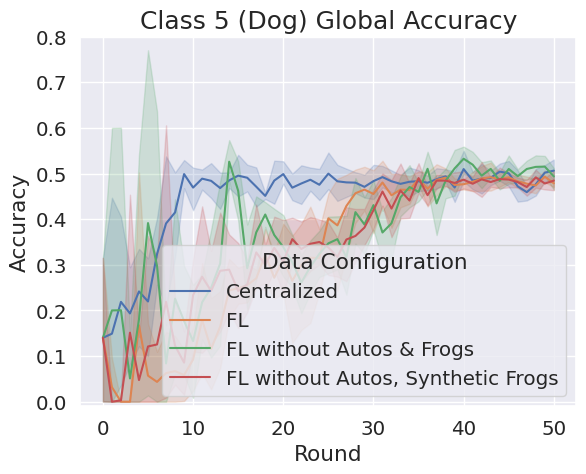

In [391]:
my_plot_one_label(df=final_df, label='5', hue='Data Configuration', replace_metric_value_string='Accuracy', title='Class 5 (Dog) Global Accuracy', ymax=YMAX_ext)

/tmp/ipykernel_1886748/1546615458.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'Metric Value': replace_metric_value_string}, inplace=True)


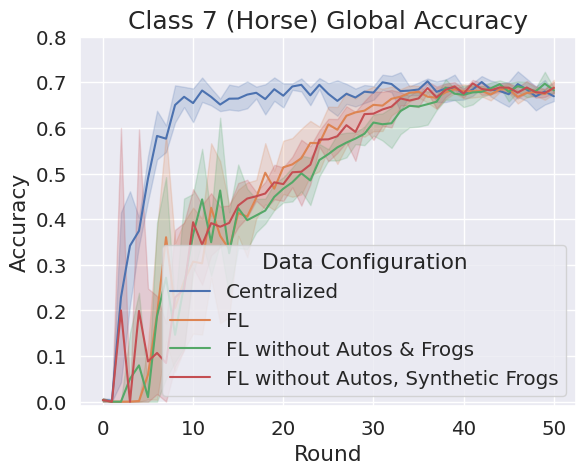

In [392]:
my_plot_one_label(df=final_df, label='7', hue='Data Configuration', replace_metric_value_string='Accuracy', title='Class 7 (Horse) Global Accuracy', ymax=YMAX_ext)

/tmp/ipykernel_1886748/1546615458.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'Metric Value': replace_metric_value_string}, inplace=True)


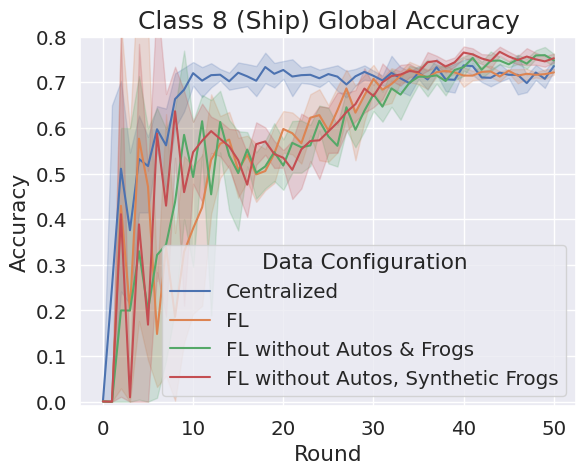

In [393]:
my_plot_one_label(df=final_df, label='8', hue='Data Configuration', replace_metric_value_string='Accuracy', title='Class 8 (Ship) Global Accuracy', ymax=YMAX_ext)

/tmp/ipykernel_1886748/1546615458.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'Metric Value': replace_metric_value_string}, inplace=True)


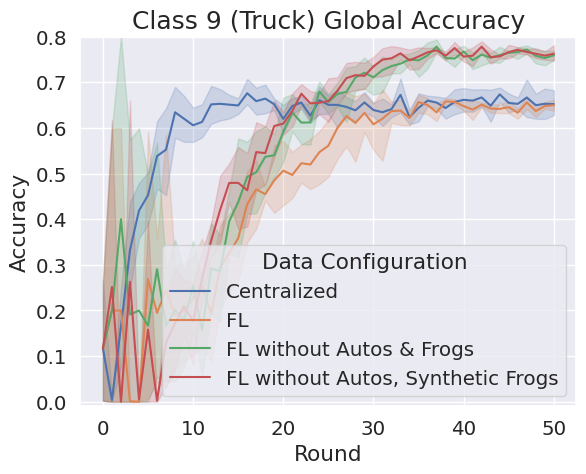

In [394]:
my_plot_one_label(df=final_df, label='9', hue='Data Configuration', replace_metric_value_string='Accuracy', title='Class 9 (Truck) Global Accuracy', ymax=YMAX_ext)

In [395]:
"""

Below is what I used when first exploring (before putting it altogether into one big df)


"""

'\n\nBelow is what I used when first exploring (before putting it altogether into one big df)\n\n\n'

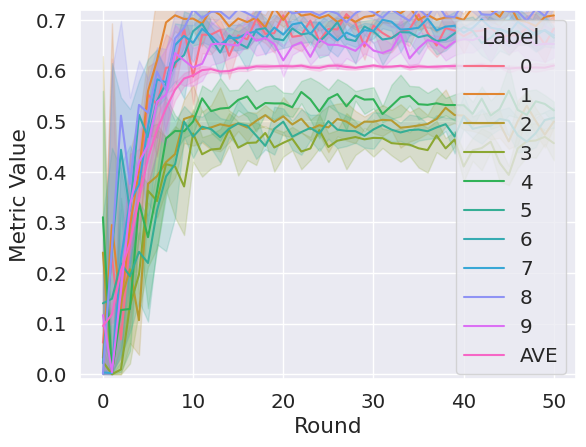

In [396]:
# These are the results before using the convnext model
my_plot_over_labels(df=baseline_centralized_df)

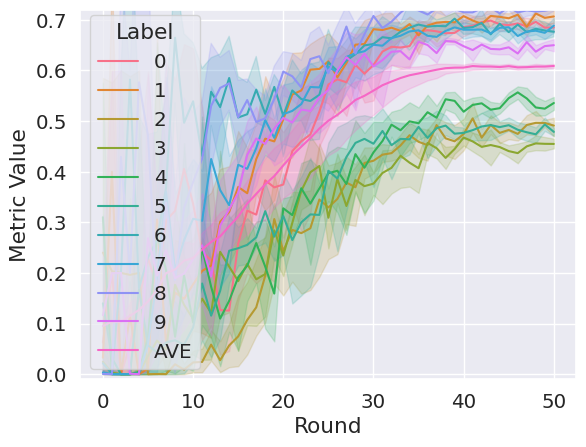

In [397]:
my_plot_over_labels(df=baseline_FL_df)

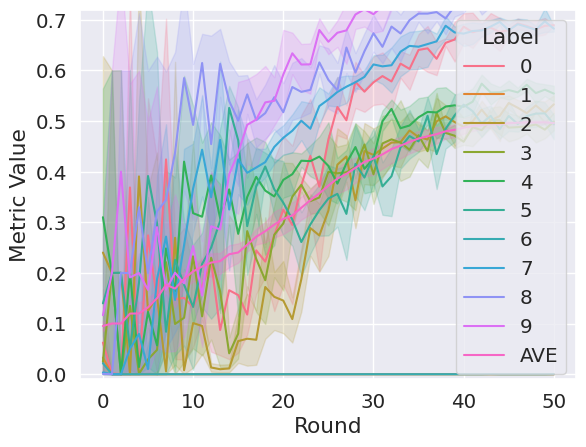

In [398]:
my_plot_over_labels(df=allmissing_two_df)

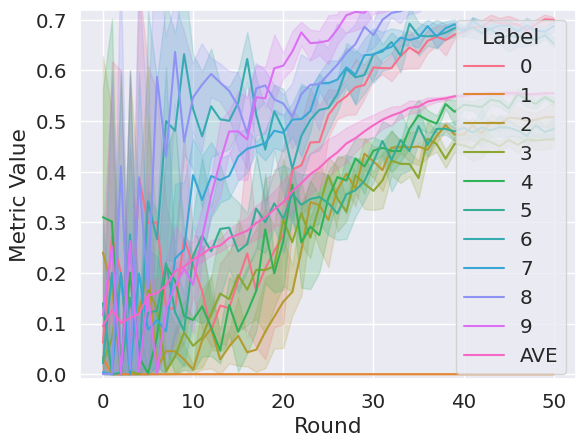

In [399]:
my_plot_over_labels(df=allmissing_two_suppone_df)

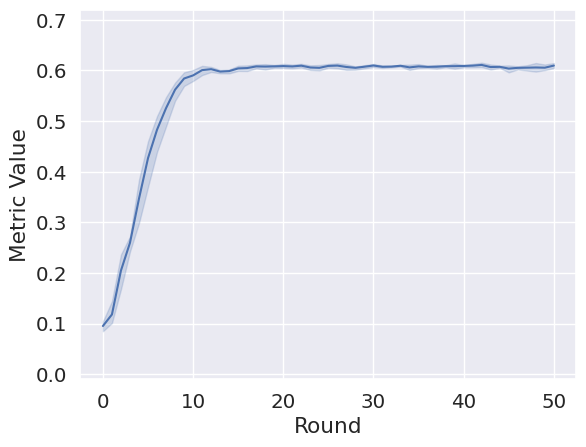

In [400]:
my_plot_ave_label(df=baseline_centralized_df)

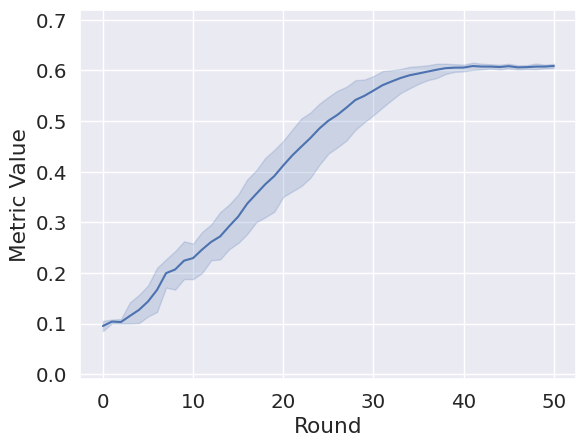

In [401]:
my_plot_ave_label(df=baseline_FL_df)

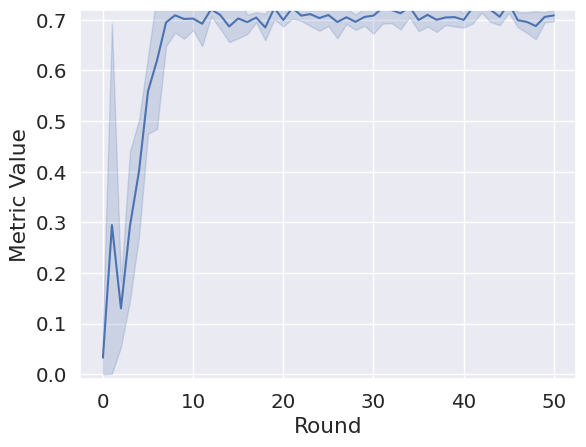

In [402]:
my_plot_one_label(df=baseline_centralized_df, label='1')     # AUTOMOBILE (FOR CENTRALIZED)

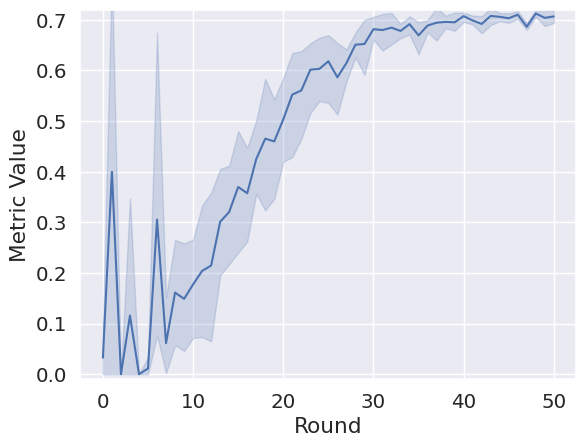

In [403]:
my_plot_one_label(df=baseline_FL_df, label='1')     # AUTOMOBILE (FOR FL)

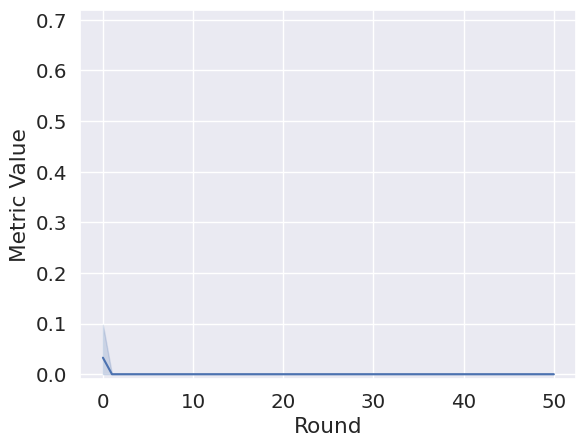

In [404]:
my_plot_one_label(df=allmissing_two_df, label='1')     # AUTOMOBILE (FOR missing AUTOMOBILE AND FROGS)

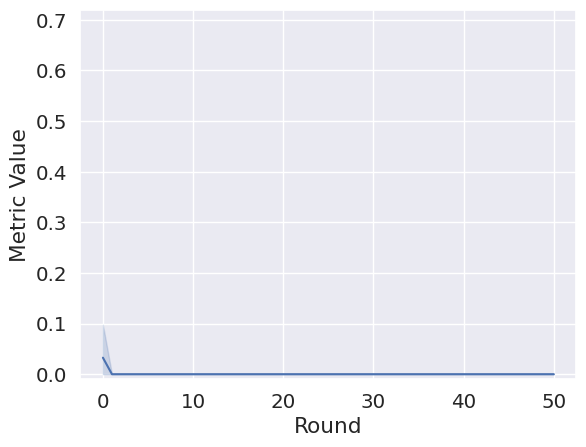

In [405]:
my_plot_one_label(df=allmissing_two_suppone_df, label='1')     # AUTOMOBILE (FOR missing AUTOMOBILE BUT SUPPLEMENTING FROGS)

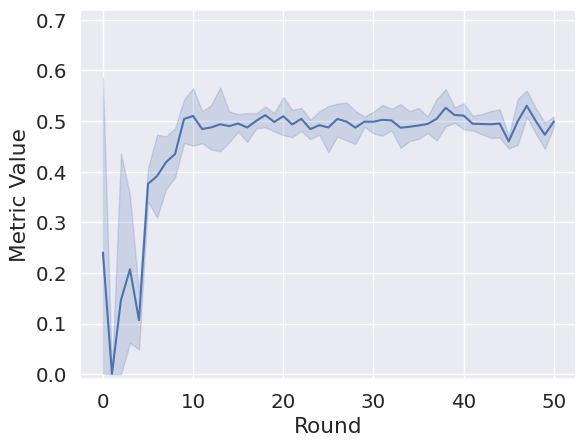

In [406]:
my_plot_one_label(df=baseline_centralized_df, label='2')     # BIRD (FOR CENTRALIZED)

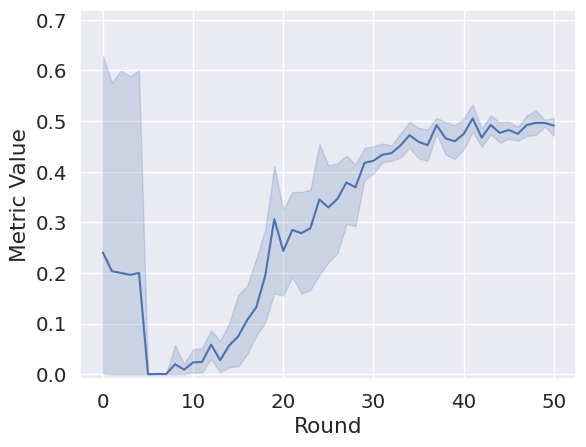

In [407]:
my_plot_one_label(df=baseline_FL_df, label='2')     # BIRD (FOR FL)

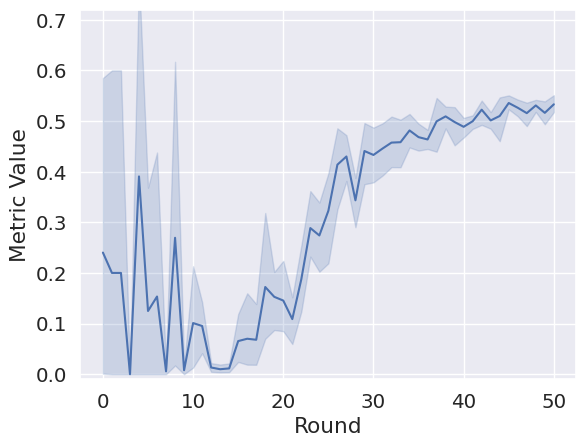

In [408]:
my_plot_one_label(df=allmissing_two_df, label='2')     # BIRD (FOR missing AUTOMOBILE AND FROGS)

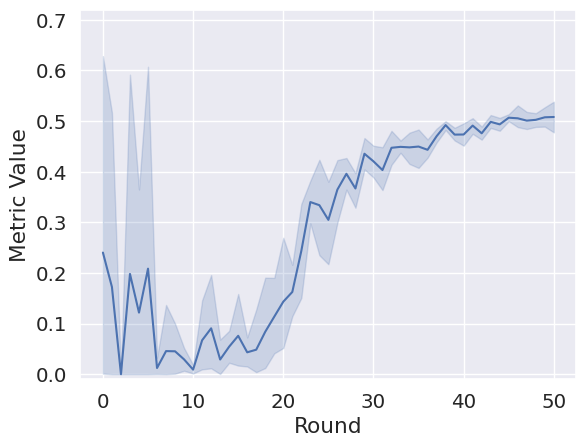

In [409]:
my_plot_one_label(df=allmissing_two_suppone_df, label='2')     # BIRD (FOR missing AUTOMOBILE BUT SUPPLEMENTING FROGS)

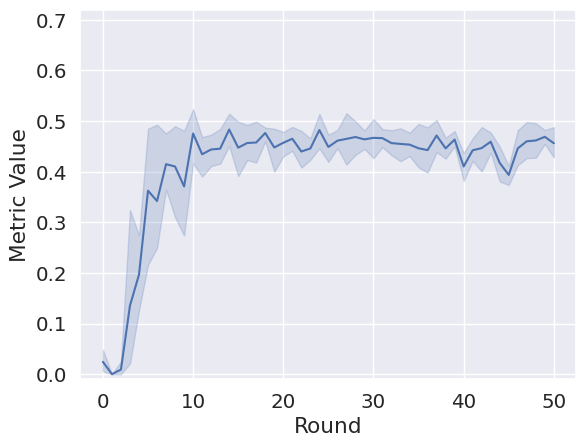

In [410]:
my_plot_one_label(df=baseline_centralized_df, label='3')     # CAT (FOR CENTRALIZED)

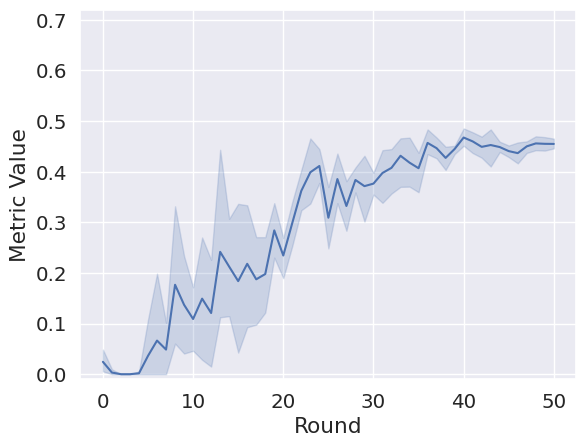

In [411]:
my_plot_one_label(df=baseline_FL_df, label='3')     # CAT (FOR FL)

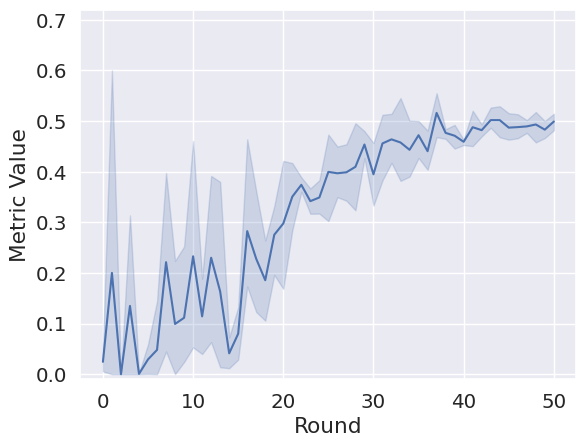

In [412]:
my_plot_one_label(df=allmissing_two_df, label='3')     # CAT (FOR missing AUTOMOBILE AND FROGS)

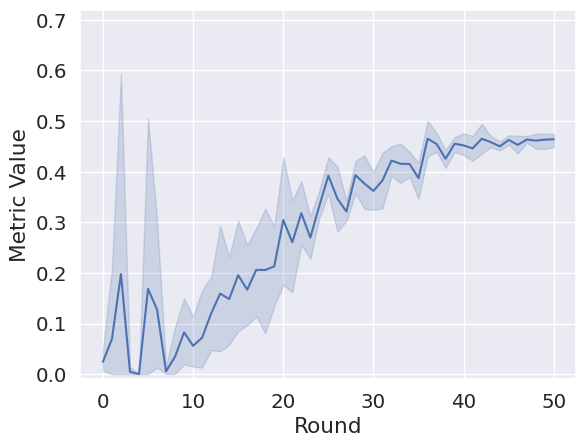

In [413]:
my_plot_one_label(df=allmissing_two_suppone_df, label='3')     # CAT (FOR missing AUTOMOBILE BUT SUPPLEMENTING FROGS)

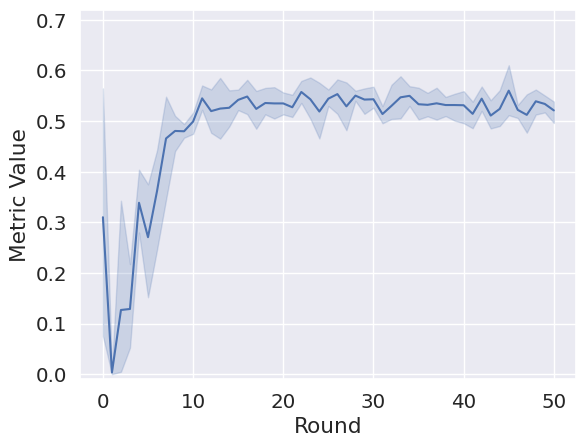

In [414]:
my_plot_one_label(df=baseline_centralized_df, label='4')     # DEER (FOR CENTRALIZED)

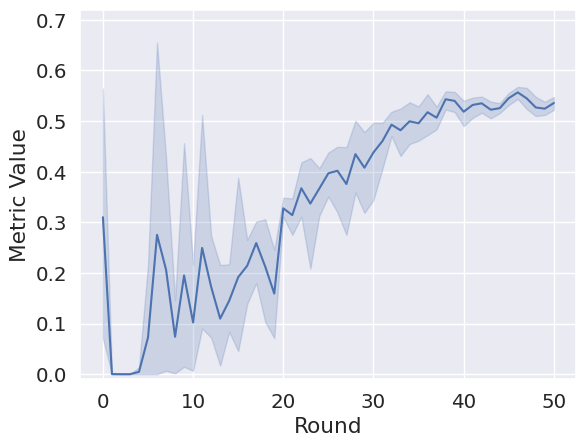

In [415]:
my_plot_one_label(df=baseline_FL_df, label='4')     # DEER (FOR FL)

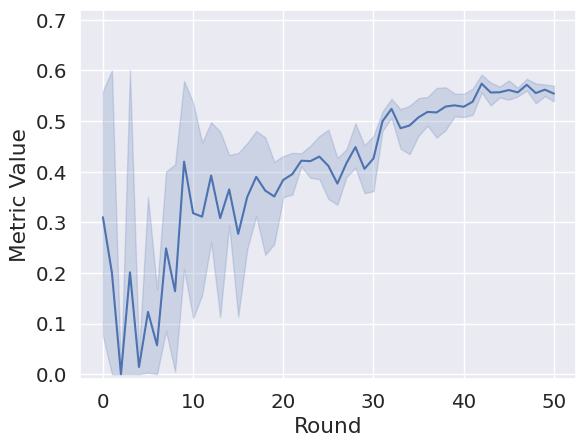

In [416]:
my_plot_one_label(df=allmissing_two_df, label='4')     # DEER (FOR missing AUTOMOBILE AND FROGS)

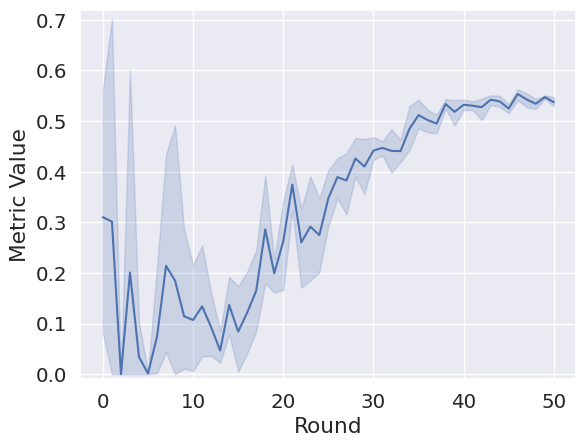

In [417]:
my_plot_one_label(df=allmissing_two_suppone_df, label='4')     # DEER (FOR missing AUTOMOBILE BUT SUPPLEMENTING FROGS)

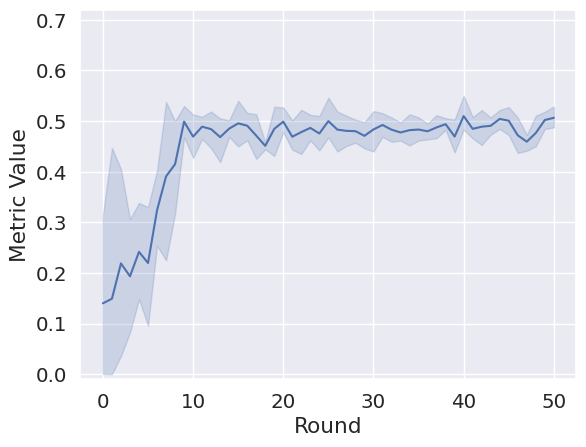

In [418]:
my_plot_one_label(df=baseline_centralized_df, label='5')     # DOG (FOR CENTRALIZED)

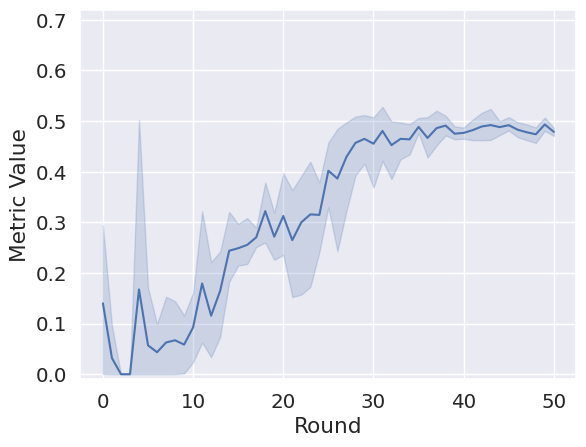

In [419]:
my_plot_one_label(df=baseline_FL_df, label='5')     # DOG (FOR FL)

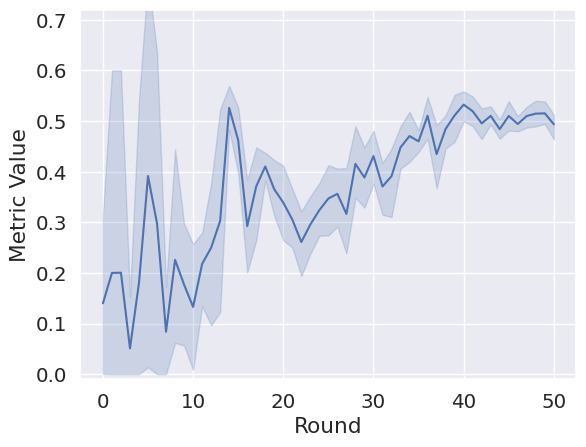

In [420]:
my_plot_one_label(df=allmissing_two_df, label='5')     # DOG (FOR missing AUTOMOBILE AND FROGS)

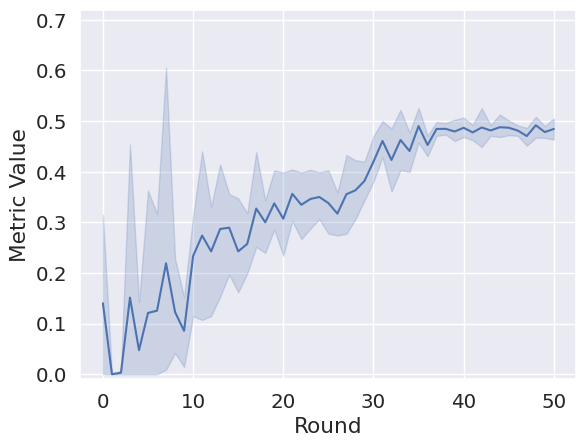

In [421]:
my_plot_one_label(df=allmissing_two_suppone_df, label='5')     # DOG (FOR missing AUTOMOBILE BUT SUPPLEMENTING FROGS)

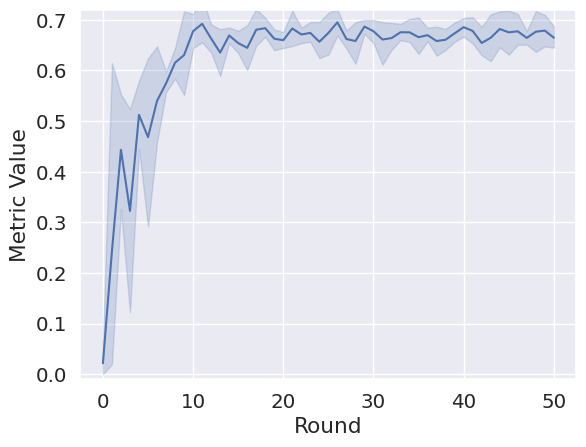

In [422]:
my_plot_one_label(df=baseline_centralized_df, label='6')     # FROG (FOR CENTRALIZED)

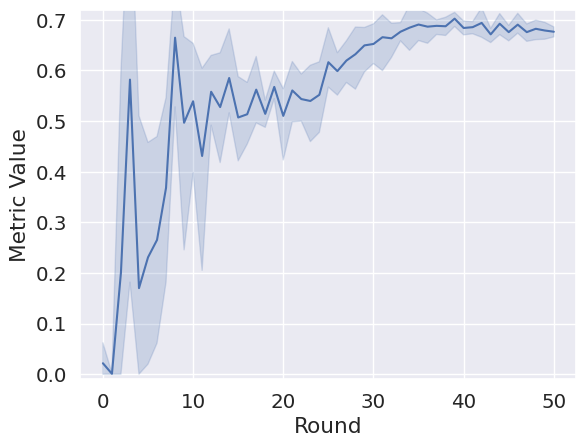

In [423]:
my_plot_one_label(df=baseline_FL_df, label='6')     # FROG (FOR FL)

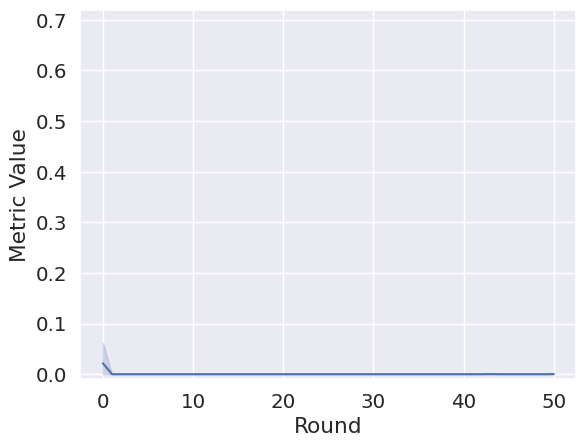

In [424]:
my_plot_one_label(df=allmissing_two_df, label='6')     # FROG (FOR missing AUTOMOBILE AND FROGS)

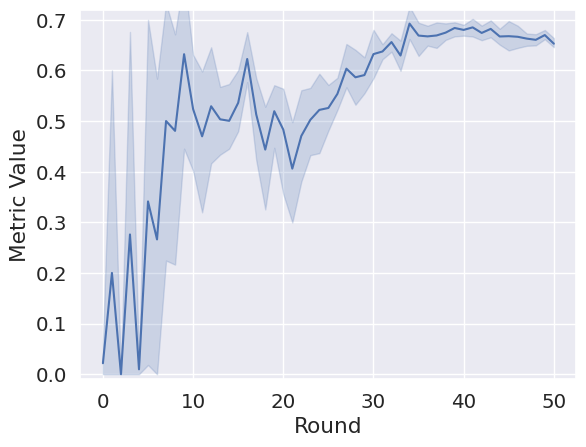

In [425]:
my_plot_one_label(df=allmissing_two_suppone_df, label='6')     # FROGS (FOR missing AUTOMOBILE BUT SUPPLEMENTING FROGS)

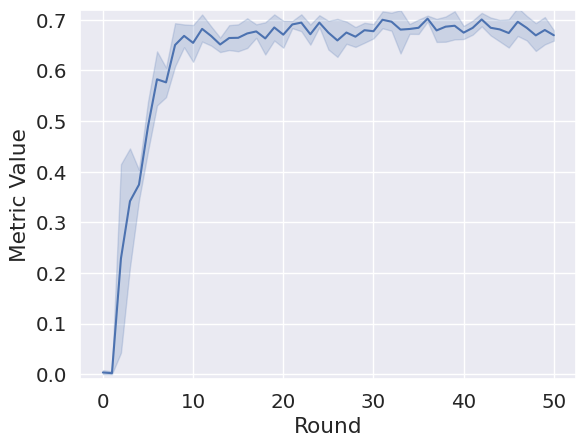

In [426]:
my_plot_one_label(df=baseline_centralized_df, label='7')     # HORSE (FOR CENTRALIZED)

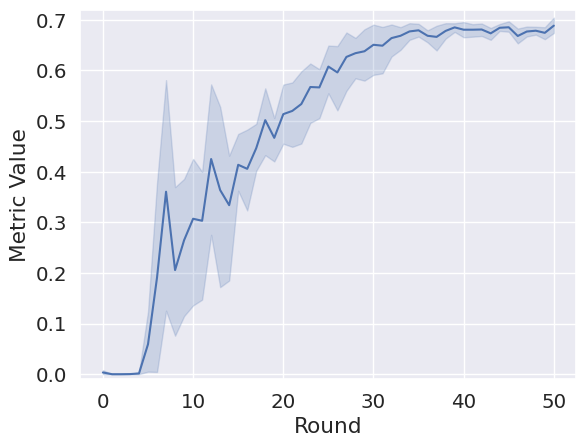

In [427]:
my_plot_one_label(df=baseline_FL_df, label='7')     # HORSE (FOR FL)

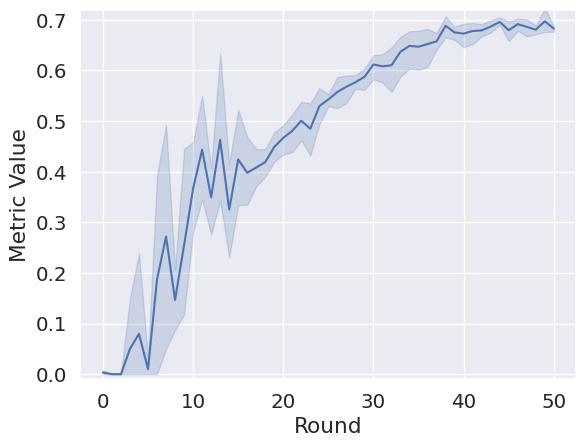

In [428]:
my_plot_one_label(df=allmissing_two_df, label='7')     # HORSE (FOR missing AUTOMOBILE AND FROGS)

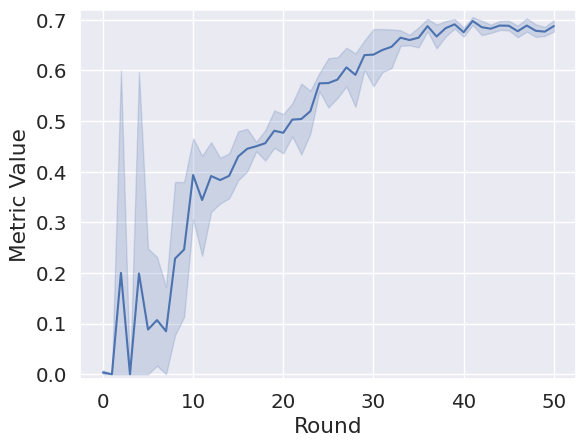

In [429]:
my_plot_one_label(df=allmissing_two_suppone_df, label='7')     # HORSE (FOR missing AUTOMOBILE BUT SUPPLEMENTING FROGS)

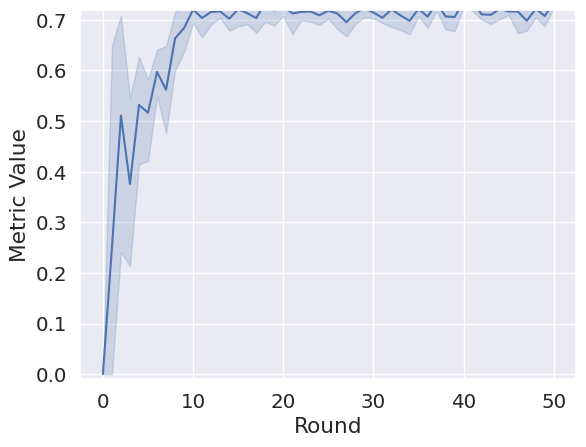

In [430]:
my_plot_one_label(df=baseline_centralized_df, label='8')     # SHIP (FOR CENTRALIZED)

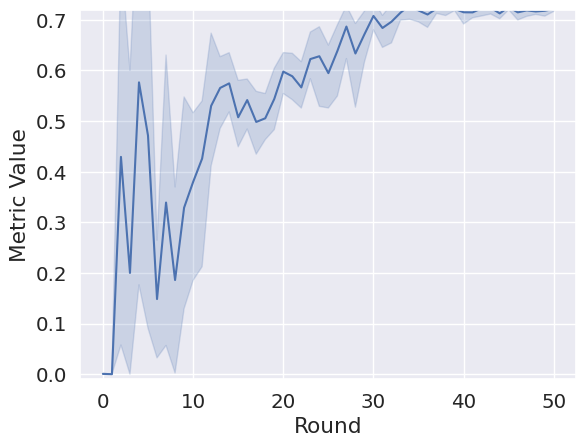

In [431]:
my_plot_one_label(df=baseline_FL_df, label='8')     # SHIP (FOR FL)

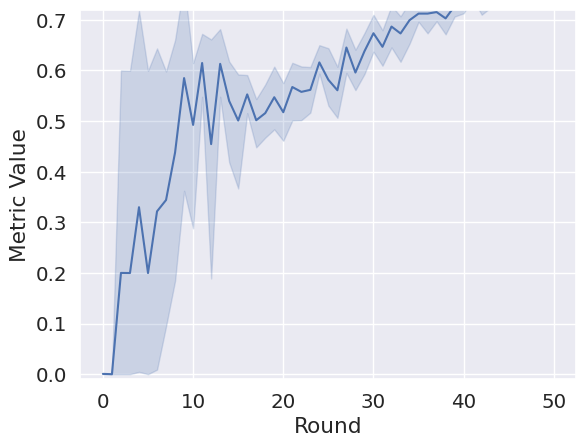

In [432]:
my_plot_one_label(df=allmissing_two_df, label='8')     # SHIP (FOR missing AUTOMOBILE AND FROGS)

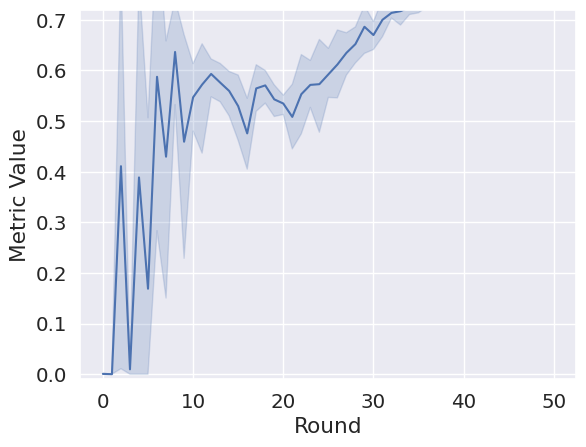

In [433]:
my_plot_one_label(df=allmissing_two_suppone_df, label='8')     # SHIP (FOR missing AUTOMOBILE BUT SUPPLEMENTING FROGS)

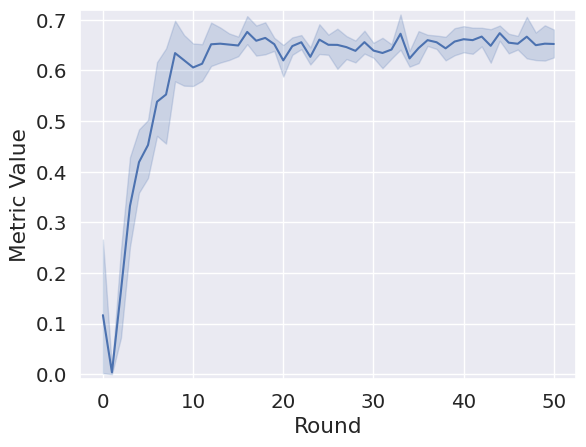

In [434]:
my_plot_one_label(df=baseline_centralized_df, label='9')     # TRUCK (FOR CENTRALIZED)

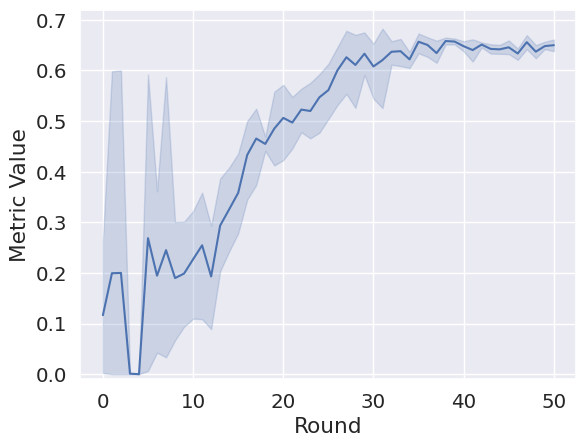

In [435]:
my_plot_one_label(df=baseline_FL_df, label='9')     # TRUCK (FOR FL)

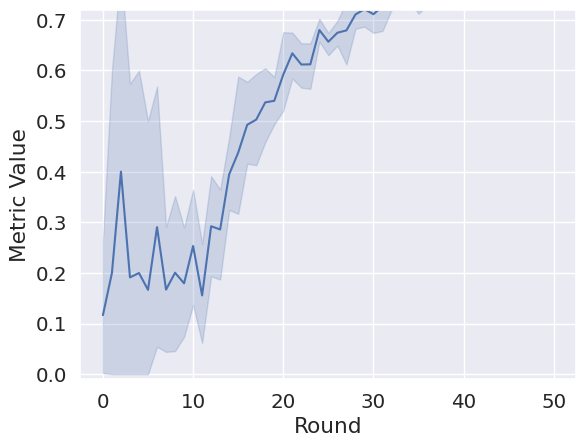

In [436]:
my_plot_one_label(df=allmissing_two_df, label='9')     # TRUCK (FOR missing AUTOMOBILE AND FROGS)

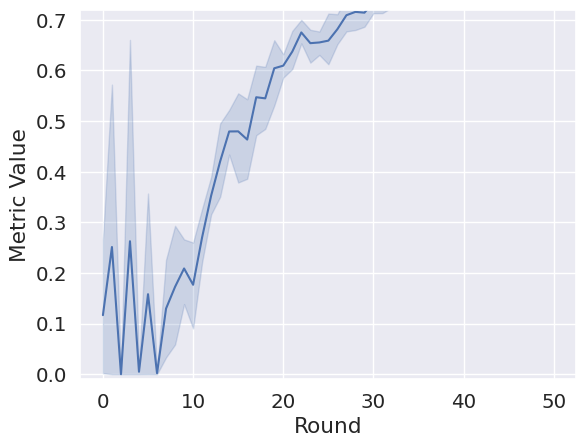

In [437]:
my_plot_one_label(df=allmissing_two_suppone_df, label='9')     # TRUCK (FOR missing AUTOMOBILE BUT SUPPLEMENTING FROGS)

In [438]:
"""
OLDER CELLS BELOW TO take from

"""

'\nOLDER CELLS BELOW TO take from\n\n'

In [439]:
# Ok we're going to plot the col 0 results as it has the most data

In [440]:
df_col0_agg = tuning_results_df[(tuning_results_df['Location']=='Col 0') & (tuning_results_df['Metric']=='Aggregated Model Accuracy')]
sns.lineplot(df_col0_agg, x='Round', y='Metric Value', hue='LearningRate')

NameError: name 'tuning_results_df' is not defined

In [ ]:
df_col0_loc = tuning_results_df[(tuning_results_df['Location']=='Col 0') & (tuning_results_df['Metric']=='Local Model Accuracy')]
sns.lineplot(df_col0_loc, x='Round', y='Metric Value', hue='LearningRate')

In [ ]:
df_col0_agg = tuning_results_df[(tuning_results_df['Location']=='Col 2') & (tuning_results_df['Metric']=='Aggregated Model Accuracy')]
sns.lineplot(df_col0_agg, x='Round', y='Metric Value', hue='LearningRate')

In [ ]:
# Looks like lr=0.11 is the way to go

In [ ]:
quicktest_results_df = accumulate_dfs(result_paths=quicktest_paths, 
                                   cross_rpath_feature_name="LearningRate")

In [ ]:
quicktest_results_df.columns

In [ ]:
quicktest_results_df['Location'].unique()

In [ ]:
quicktest_results_df['Label'].unique()

In [ ]:
df_All_agg = quicktest_results_df[(quicktest_results_df['Location']=='All') & (quicktest_results_df['Metric']=='Aggregated Model Accuracy') & (quicktest_results_df['Label']=='AVE')]
sns.lineplot(df_All_agg, x='Round', y='Metric Value', hue='LearningRate')

In [ ]:
# Final test considering diffrent augmentation sizes for the same learning rate (0.11)

In [ ]:
aug_size_results_df = accumulate_dfs(result_paths=test_over_size_rpaths, 
                                   cross_rpath_feature_name="AugmentationSize")

In [ ]:
size_df_All_agg = aug_size_results_df[(aug_size_results_df['Location']=='Col 0') & 
                                      (aug_size_results_df['Metric']=='Aggregated Model Accuracy') & 
                                      (aug_size_results_df['Label']=='6')]
sns.lineplot(size_df_All_agg, x='Round', y='Metric Value', hue='AugmentationSize')

In [ ]:
size_df_All_agg = aug_size_results_df[(aug_size_results_df['Location']=='Col 0') & 
                                      (aug_size_results_df['Metric']=='Aggregated Model Accuracy') & 
                                      (aug_size_results_df['Label']=='6') & 
                                      (aug_size_results_df['AugmentationSize']!='0')]
sns.lineplot(size_df_All_agg, x='Round', y='Metric Value', hue='AugmentationSize')

In [ ]:
size_df_All_agg = aug_size_results_df[(aug_size_results_df['Metric']=='Local Model Accuracy') & 
                                      (aug_size_results_df['Label']=='6') & 
                                      (aug_size_results_df['AugmentationSize']=='0')]
sns.lineplot(size_df_All_agg, x='Round', y='Metric Value', hue='Location')

In [ ]:
size_df_All_agg = aug_size_results_df[(aug_size_results_df['Metric']=='Local Model Accuracy') & 
                                      (aug_size_results_df['Label']=='6') & 
                                      (aug_size_results_df['AugmentationSize']=='0') & 
                                      (aug_size_results_df['Round']==1)]
size_df_All_agg.head()

In [ ]:
size_df_All_agg = aug_size_results_df[(aug_size_results_df['Location']=='6') & (aug_size_results_df['Metric']=='Aggregated Model Accuracy') & (aug_size_results_df['Label']=='6')]
sns.lineplot(size_df_All_agg, x='Round', y='Metric Value', hue='AugmentationSize')

In [ ]:
# Repeat final test (diffrent augmentation sizes for the same learning rate of 0.11) this time limiting the number of class
# 6 examples present for col 0 so as to not allow such quick learning of class 6 there

In [ ]:
aug_size_results_df = accumulate_dfs(result_paths=test_over_size_lessclass6_rpaths, 
                                   cross_rpath_feature_name="AugmentationSize")

In [ ]:
size_df_All_agg = aug_size_results_df[(aug_size_results_df['Location']=='Col 0') & 
                                      (aug_size_results_df['Metric']=='Aggregated Model Accuracy') & 
                                      (aug_size_results_df['Label']=='6') & 
                                      (aug_size_results_df['AugmentationSize']=='2100')]
sns.lineplot(size_df_All_agg, x='Round', y='Metric Value', hue='AugmentationSize')

In [ ]:
size_df_All_agg = aug_size_results_df[(aug_size_results_df['Location']=='Col 0') & 
                                      (aug_size_results_df['Metric']=='Aggregated Model Accuracy') & 
                                      (aug_size_results_df['Label']=='6') & 
                                      (aug_size_results_df['AugmentationSize']=='0')]
sns.lineplot(size_df_All_agg, x='Round', y='Metric Value', hue='AugmentationSize')

In [ ]:
size_df_All_agg = aug_size_results_df[(aug_size_results_df['Location']=='Col 0') & 
                                      (aug_size_results_df['Metric']=='Aggregated Model Accuracy') & 
                                      (aug_size_results_df['Label']=='5') & 
                                      (aug_size_results_df['AugmentationSize']=='0')]
sns.lineplot(size_df_All_agg, x='Round', y='Metric Value', hue='AugmentationSize')

In [ ]:
size_df_All_agg = aug_size_results_df[(aug_size_results_df['Location']=='All') & 
                                      (aug_size_results_df['Metric']=='Aggregated Model Accuracy') & 
                                      (aug_size_results_df['Label']=='AVE')]
sns.lineplot(size_df_All_agg, x='Round', y='Metric Value', hue='AugmentationSize')

In [ ]:
size_df_All_agg = aug_size_results_df[(aug_size_results_df['Location']=='Col 0') & 
                                      (aug_size_results_df['Metric']=='Aggregated Model Accuracy') & 
                                      (aug_size_results_df['Label']=='All')]
sns.lineplot(size_df_All_agg, x='Round', y='Metric Value', hue='AugmentationSize')